## Initial Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi # to find GPU memory => use 90 to 95% of memory. minibatch size to power of 2
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install 'fsspec>=0.3.3'

In [ ]:
import dask.bag as db
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import json
import pandas as pd
import numpy as np
from scipy import sparse 
from pandas.api.types import CategoricalDtype 
from tqdm import tqdm, trange
from IPython.utils import io
import spacy
from spacy.lang.en.stop_words import STOP_WORDS 
import re

import string
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn import metrics
import seaborn as sns
import plotly.express as px
import torch.nn as nn
import torch 
import altair as alt
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from collections import Counter
from sklearn.preprocessing import normalize
import random
import pickle
import scipy
import os
import requests
%matplotlib inline

## Load Initial Data and Trim (trimmed_arxiv_docs.pickle) 

### Load Raw JSON data

1.   Use `dask.bag.read_text()` to map each line of the input file to a list. (https://docs.dask.org/en/stable/bag-creation.html)
2.   Use `.map(json.loads)` to apply `json.loads` to each entry line, converting it to a python native dictionary  

In [ ]:
docs = db.read_text("./drive/MyDrive/Colab Notebooks/CE/data/arxiv-metadata-oai-snapshot.json").map(json.loads)

In [ ]:
print("Total Documents: " + str(docs.count().compute()))
print("\nExample Document: ")
docs.take(1)

Total Documents: 2018208

Example Document: 


({'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection 

In [ ]:
[ x[1] + " " + x[0] for x in docs.take(1)[0]['authors_parsed']]

['C. Balázs', 'E. L. Berger', 'P. M. Nadolsky', 'C. -P. Yuan']

In [ ]:
[ " ".join(x[:2]) for x in docs.take(1)[0]['authors_parsed']]

['Balázs C.', 'Berger E. L.', 'Nadolsky P. M.', 'Yuan C. -P.']

### Sample by year

To access the year from `'versions': [{'created': 'Mon, 2 Apr 2007 19:18:42 GMT', 'version': 'v1'}, ...]`, we do the following:


1.   `get_latest_version` is a lambda function to access the `created` value of the most recent version which is always last so `[-1]` indexing is used.
2.   We can then split the date by spaces and access the `[3]` index in the array to get the year by itself.

In [ ]:
get_latest_version = lambda x: x['versions'][-1]['created']
print("Full date:\n" + get_latest_version(docs.take(1)[0])) # .take returns tuple with 1 value: Need [0] index 
print("\nYear alone:\n" + get_latest_version(docs.take(1)[0]).split(' ')[3])

Full date:
Tue, 24 Jul 2007 20:10:27 GMT

Year alone:
2007


Here, a trimmed dataset is created for prototyping based on the most recent version's year:


1.   The `trim` takes the data points from eacch document entry that we want. We also spluit the `categories` string into an array.
2.   The entire docs list is filtered by `get_latest_version`, defined above, to only take documents with a date greater than 2018. The trim funcion is then mapped onto the output to reduce the number of predictors. `.compute` converts a 'lazy Dask collection` into the in-memory equivalent. In this case thats a Dask array into a NumPy array.
3.   The array is converted into data frame stored in `docs_df`.
4.   The data frame is saved as a pickle file for easier start up in future run times useing `to_pickle`.


In [ ]:
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2018)
           .map(trim).
           compute())

docs_df = pd.DataFrame(docs_df)

### Sample by doi

Gets all documents that contain a doi. Also includes udpated emthod for getting authors from authors_parsed.

In [ ]:
trim = lambda x: {'id': x['id'],
                  'authors': [ " ".join(y[:2]) for y in x['authors_parsed']],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}

docs_df = (docs.filter(lambda x: x['doi'] != None)
           .map(trim).
           compute())

docs_df = pd.DataFrame(docs_df)

In [ ]:
len(docs_df)

1026475

In [ ]:
docs_df.head(2)

,id,authors,title,doi,category,abstract
0,0704.0001,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",Calculation of prompt diphoton production cros...,10.1103/PhysRevD.76.013009,[hep-ph],A fully differential calculation in perturba...
1,0704.0006,"[Pong Y. H., Law C. K.]",Bosonic characters of atomic Cooper pairs acro...,10.1103/PhysRevA.75.043613,[cond-mat.mes-hall],We study the two-particle wave function of p...


### Save to "trimmed_arxiv_docs.pickle"

In [ ]:
docs_df.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/trimmed_docs.pickle")

## Data Cleaning (trimmed_cleaned_arxiv_docs.pickle)


In [ ]:
df = docs_df

### Load trimmed_arxiv_docs.pickle

Here, the saved csv file is loaded into the dataframe, `df`.

In [ ]:
df = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/trimmed_arxiv_docs.pickle")
print("number of entries: "+ str(len(df)))
df.head(3)

number of entries: 581895


,id,authors,title,doi,category,abstract
0,0704.0479,T.Geisser,The affine part of the Picard scheme,None,"[math.AG, math.KT]",We describe the maximal torus and maximal un...
1,0704.1445,Yasha Gindikin and Vladimir A. Sablikov,Deformed Wigner crystal in a one-dimensional q...,10.1103/PhysRevB.76.045122,"[cond-mat.str-el, cond-mat.mes-hall]",The spatial Fourier spectrum of the electron...
2,0705.0033,"Nikos Frantzikinakis, Randall McCutcheon",Ergodic Theory: Recurrence,None,[math.DS],We survey the impact of the Poincar\'e recur...


### Summarize Raw Trimmed Data


In [ ]:
print("Shape: " + str(df.shape) + "\n")

df.info()

Shape: (1026475, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026475 entries, 0 to 1026474
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   id        1026475 non-null  object
 1   authors   1026475 non-null  object
 2   title     1026475 non-null  object
 3   doi       1026475 non-null  object
 4   category  1026475 non-null  object
 5   abstract  1026475 non-null  object
dtypes: object(6)
memory usage: 47.0+ MB


### Abstract Word Count
A lambda function can be applied to the `abstract` column of each entry to count the total number of words in the abstract and then saved in `abstract_word_count`.

In [ ]:
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split())) 
df.head(2)

,id,authors,title,doi,category,abstract,abstract_word_count
0,0704.0001,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",Calculation of prompt diphoton production cros...,10.1103/PhysRevD.76.013009,[hep-ph],A fully differential calculation in perturba...,140
1,0704.0006,"[Pong Y. H., Law C. K.]",Bosonic characters of atomic Cooper pairs acro...,10.1103/PhysRevA.75.043613,[cond-mat.mes-hall],We study the two-particle wave function of p...,143


### Remove Duplicates
Looking at the `abstract` column, there are more abstracts than unique abstracts.

In [ ]:
df['abstract'].describe(include='all')

count                                               1026475
unique                                              1026139
top         Discussion of "A statistical analysis of mul...
freq                                                     13
Name: abstract, dtype: object

The rows with duplicate abstracts are dropped like so:

In [ ]:
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                               1026139
unique                                              1026139
top         A fully differential calculation in perturba...
freq                                                      1
Name: abstract, dtype: object

### Save to "trimmed_cleaned_arxiv_docs.pickle"

In [ ]:
df.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/trimmed_cleaned_arxiv_docs.pickle")

## Interaction dataframe (interaction_df.pickle)


### Load "trimmed_cleaned_arxiv_docs.pickle"

In [ ]:
df = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/hasDOI/trimmed_cleaned_arxiv_docs.pickle")
print("number of entries: "+ str(len(df)))
df.head(3)

number of entries: 1026139


,id,authors,title,doi,category,abstract,abstract_word_count
0,0704.0001,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",Calculation of prompt diphoton production cros...,10.1103/PhysRevD.76.013009,[hep-ph],A fully differential calculation in perturba...,140
1,0704.0006,"[Pong Y. H., Law C. K.]",Bosonic characters of atomic Cooper pairs acro...,10.1103/PhysRevA.75.043613,[cond-mat.mes-hall],We study the two-particle wave function of p...,143
2,0704.0007,"[Corichi Alejandro, Vukasinac Tatjana, Zapata ...",Polymer Quantum Mechanics and its Continuum Limit,10.1103/PhysRevD.76.044016,[gr-qc],A rather non-standard quantum representation...,156


### Explode "authors_split" into unique rows

From here: [Recommender Systems Item Customer Collaborative Filtering](https://towardsdatascience.com/recommender-systems-item-customer-collaborative-filtering-ff0c8f41ae8a)

First the cleaned and trimmed data must be reorganized into a dataframe holding only the interactions between papers and users. For this data set we are holding interatction to be author to paper relationships.


1.   Only the `['id', 'authors_split']` columns are taken as they hold all the relationship information
2.   The dataframe is exploded by the `'authors_split'` column to get 1 row per author to paper interaction.
3.   [**Optional**] - The columns are renamed from `['authors_split', 'id']` to `['author', 'document']`.

In [ ]:
interaction_df = df[['id', 'authors_split']]
interaction_df = interaction_df.explode('authors_split')
interaction_df = interaction_df.rename(columns = {'authors_split': 'author', 'id': 'document' })
print("Number of paper to author mappings: " + str(len(interaction_df)) + "\n")
interaction_df.head(10)

Number of paper to author mappings: 2894399



,document,author
0,0704.0479,T.Geisser
1,0704.1445,Yasha Gindikin
1,0704.1445,Vladimir A. Sablikov
2,0705.0033,Nikos Frantzikinakis
2,0705.0033,Randall McCutcheon
3,0705.0344,J. P. Pridham
4,0705.0825,Ram Gopal Vishwakarma (Zacatecas University)
5,0705.2562,Ken D. Olum
5,0705.2562,Delia Schwartz-Perlov
6,0705.3164,Gabriel Vigny


### Save to "interaction_df.pickle" 

In [ ]:
interaction_df.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/interaction_df.pickle")

## Sparse Matrix (sparse_matrix.pickle, idx2auth.pickle, idx2doc.pickle)

### Load "interaction_df.pickle"

In [ ]:
interaction_df = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/interaction_df.pickle")
print("number of entries: "+ str(len(df)))
interaction_df.head(3)

number of entries: 581780


,document,author
0,0704.0479,T.Geisser
1,0704.1445,Yasha Gindikin
1,0704.1445,Vladimir A. Sablikov


### Build Sparse Matrix

**`scipy.sparse.csr_matrix()`** will be used to save memory and increase calculation speed. It avoids storing 0 entries in the matrix and instead smartly encodes the non 0 values in a sparse matrix by storing the row indeces, column indices and values of every non 0 entry in the matrix. Everything else is assumed to be 0.
 
The form of **`scipy.sparse.csr_matrix()`** that will be used is:

**`csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])`** 


where **`data`**, **`row_ind`** and **`col_ind`** satisfy the relationship:

 **`a[row_ind[k], col_ind[k]] = data[k]`** 
 
 More details can be found here: [SciPy Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)


For the author-paper interaction, matrix rows represent authors and columns represent papers with evey interaction between the two recieving the value of $1$. First, a unique list of authors  and a unique list of documents are generated and stored in **`authors`** and **`documents`**, respectivley. The length of **`authors`** is the number of rows and the length of **`documents`** is the number of columns in the interaction matrix.

The values above are then defined as a 3-tuple where:

*   **`row_ind = `** index of an author in **`authors`**
*   **`col_ind = `** index of a document in **`documents`**
*   **`data = `** list of $1$s with the same length as our total number of interactions or **`len(interaction_df)`**.

Therefore **`data`**, **`row_ind`** and **`col_ind`** must all be of the same length. To get the indices, the author and document columns are converted to a categorical type where the categories are the respective number of unique values in each column.  **`.cat.codes`** is then applied to convert them to a numeric value corresponding to each unique categorical variabe. This has the effect of creating a list of indices where each index matches a unique entry in the **`authors`** and **`documents`** lists.



In [ ]:
# authors / rows ===============================================================
authors = list(np.sort(interaction_df.author.unique()))
print('Number of authors: ' + str(len(authors)))
print('10 authors: ' + str(authors[:10]))

rows = interaction_df.author.astype(CategoricalDtype(categories= authors)).cat.codes 
print('entry index vs unique author index: \n' + str(rows[:]))

# documents / cols ===============================================================
documents = list(interaction_df.document.unique())
print('\nNumber of documents: ' + str(len(documents)))
print('10 documents: ' + str(documents[:10]))

cols = interaction_df.document.astype(CategoricalDtype(categories= documents)).cat.codes  
print('entry index vs unique document index: \n' + str(cols[:10]))

# interactions / matrix values =================================================
interactionStrength = [1] * len(interaction_df)
print('\nNumber of interactions: ' + str(len(interactionStrength)))
print('10 interactions: ' + str(interactionStrength[:10]))

Number of authors: 972506
10 authors: ['"Honza"\n  Cernock\'y', '"S. F. S\\\'anchez"', '$)\n  ((1) Department of Computational Medicine', '%Q. Riffard', '& ENS-Kouba Algiers)', '( (1) Univ. of Tokyo', '( 2 )\n  Universidad de La Laguna', '( 2 )\n  V.G. Khlopin Radium Institute)', '((1)', '((1)\n  Dept. of Computer Science']
entry index vs unique author index: 
0    832447
1    927969
1    887038
2    640899
2    716917
3    386361
4    715539
5    475240
5    219691
6    302091
dtype: int32

Number of documents: 581780
10 documents: ['0704.0479', '0704.1445', '0705.0033', '0705.0344', '0705.0825', '0705.2562', '0705.3164', '0705.4004', '0705.4060', '0705.4151']
entry index vs unique document index: 
0    0
1    1
1    1
2    2
2    2
3    3
4    4
5    5
5    5
6    6
dtype: int32

Number of interactions: 2894399
10 interactions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Now we actually create the sparse matrix of size $(unique \space authors \times unique \space documents)$. Each pair of indices in **`(rows, cols)`** indicates the corresponding entry in the matrix should be filled with the corresponding entry in **`interactionStrength`** which is always $1$. Every other entry is considered to be $0$. 

In [ ]:
interaction_sparse = sparse.csr_matrix((interactionStrength, (rows, cols)), shape=(len(authors), len(documents))) 
interaction_sparse

<972506x581780 sparse matrix of type '<class 'numpy.longlong'>'
	with 2882989 stored elements in Compressed Sparse Row format>

Here, the actual sparsity of the interaction matrix is calculated as:
$$
sparsity = 100(1 - \frac{nonzero \space entries}{matrix \space size})
$$

We find that $99.99949$% of the matrix entries are 0 values making the interaction matrix extremely sparse.

In [ ]:
matrix_size = interaction_sparse.shape[0]*interaction_sparse.shape[1]
interaction_amount = len(interaction_sparse.nonzero()[0])
sparsity = 100*(1 - (interaction_amount/matrix_size))
sparsity

99.99949044401309

### Using Sparse Matrix

#### Sparse Matrix Structure

In [ ]:
print("type of sparse matrix: " + str(type(interaction_sparse)))
print("\nShape of sparse matrix: " + str(interaction_sparse.shape))
print("\nnonzero entries of sparse matrix: ")
print("    rows or people:       " + str(interaction_sparse.nonzero()[0]))
print("    columns or documents: " + str(interaction_sparse.nonzero()[1]))

type of sparse matrix: <class 'scipy.sparse.csr.csr_matrix'>

Shape of sparse matrix: (972506, 581780)

nonzero entries of sparse matrix: 
    rows or people:       [     0      1      2 ... 972503 972504 972505]
    columns or documents: [477657 343615 308634 ... 408477 271554 371810]


#### Accessing 0 and non 0 entries

Here we define a function to return a non zero value from a sparse matrix based on its index in the sparse matrix storage

In [ ]:
def getNonZeroByIndex(sparse_m, idx, printOutput=False):
  nonzero_values = sparse_m.nonzero()
  author_index = nonzero_values[0][idx]
  document_index = nonzero_values[1][idx]
  interaction_value = sparse_m[author_index, document_index]
  if printOutput:
    print("\n======================== Get Non Zero Entry by Index ========================")
    print("index in sparse matrix storage: " + str(idx))
    print("author index: " + str(author_index))
    print("document index: " + str(document_index))
    print("interaction value: " + str(interaction_value))
  return author_index, document_index, interaction_value

We can use `getZeroByIndex()` to then get and print the author and document indices

In [ ]:
getNonZeroByIndex(sparse_m=interaction_sparse, idx=5000, printOutput=True)


======================== Get Non Zero Entry by Index ========================
index in sparse matrix storage: 5000
author index: 3992
document index: 87364
interaction value: 1


(3992, 87364, 1)

Or, we can choose indeces at random with a 99.999% chance of getting a 0 due to the sparsity of the matrix.

In [ ]:
random.seed(200)
auth_rand_idx = random.randint(0, len(authors))
doc_rand_idx =random.randint(0, len(documents))
interaction_rand_value = interaction_sparse[auth_rand_idx, doc_rand_idx]
print("\n======================== Random Sparse Matrix Entry ========================")
print("author index: " + str(auth_rand_idx))
print("document index: " + str(doc_rand_idx))
print("interaction value: " + str(interaction_rand_value))


======================== Random Sparse Matrix Entry ========================
author index: 47824
document index: 213329
interaction value: 0


#### Sparse Matrix 2 Document / Author

Here I redefine `authors` and `documents` to `idx2auth` and `idx2doc` as thats essentially what they are. You can input indeces from the sparse amtrix and get back to the original authors or documents.

In [ ]:
idx2auth = authors
idx2doc = documents

Here we look at the `interaction_sparse` matrix at index 52244 to get the author and document who correspond to this interaction. We then use the document id to find all rows of the interaction data frame that match.

We can also find the title and match the returned authors to the original document authors to make sure they match up. [COMET Phase-I Technical Design Report](https://arxiv.org/abs/1812.09018)

In [ ]:
auth_idx, doc_idx, interaction_val = getNonZeroByIndex(sparse_m=interaction_sparse, idx=52244, printOutput=True)

print("\nauthor: " + idx2auth[auth_idx])
print("document: " + idx2doc[doc_idx])

print("\ndocument title: " + df.loc[df['id'] == documents[doc_idx]]['title'].tolist()[0] + "\n")

interaction_df.loc[interaction_df['document'] == documents[doc_idx]]


======================== Get Non Zero Entry by Index ========================
index in sparse matrix storage: 52244
author index: 24754
document index: 46129
interaction value: 1

author: A. E. Bondar
document: 1812.09018

document title: COMET Phase-I Technical Design Report



,document,author
46132,1812.09018,The COMET Collaboration: R. Abramishvili
46132,1812.09018,G. Adamov
46132,1812.09018,"R. R. Akhmetshin,\n A. Allin"
46132,1812.09018,J. C. Ang\'elique
46132,1812.09018,V. Anishchik
...,...,...
46132,1812.09018,Yu. V. Yudin
46132,1812.09018,M. V. Zdorovets
46132,1812.09018,J. Zhang
46132,1812.09018,Y. Zhang


### Saving "sparse_matrix.pickle", "idx2auth.pickle", "idx2doc.pickle"

In [ ]:
type(idx2auth)

list

In [ ]:
scipy.sparse.save_npz("./drive/MyDrive/Colab Notebooks/CE/data/interaction_sparse.npz", interaction_sparse)

with open("./drive/MyDrive/Colab Notebooks/CE/data/idx2auth.pickle", "wb") as fp:
  pickle.dump(idx2auth, fp)

with open("./drive/MyDrive/Colab Notebooks/CE/data/idx2doc.pickle", "wb") as fp:
  pickle.dump(idx2doc, fp)

## Convert interaction to matrix authors and documents to ids


In [ ]:
documents_with_embeddings = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/documents_with_embeddings.pickle")

In [ ]:
documents_with_embeddings.head(2)

,id,title,abstract,authors_split,embeddings
0,0704.0479,The affine part of the Picard scheme,We describe the maximal torus and maximal un...,[T.Geisser],"[-0.0015220479108393192, -0.021295614540576935..."
1,0704.1445,Deformed Wigner crystal in a one-dimensional q...,The spatial Fourier spectrum of the electron...,"[Yasha Gindikin, Vladimir A. Sablikov]","[0.06974620372056961, 0.026879271492362022, 0...."


In [ ]:
interaction_sparse = scipy.sparse.load_npz("./drive/MyDrive/Colab Notebooks/CE/data/interaction_sparse.npz")

In [ ]:
print("idx2auth example: " + str(idx2auth[2]))
interaction_id = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/interaction_id.pickle")

idx2auth example: $)
  ((1) Department of Computational Medicine


In [ ]:
interaction_id.head(2)

,document_id,auth_id
0,0,832447
1,1,927969


In [ ]:
interaction_sparse[2, 308635]

0

In [ ]:
interaction_id.loc[interaction_id['auth_id'] == 2]

,document_id,auth_id
308680,308634,2


In [ ]:
documents_with_embeddings.iloc[308634]

id                                                      2008.03380
title            Single Cell Transcriptome Research in Human Pl...
abstract           Human placenta is a complex and heterogeneou...
authors_split    [Hui Li (1), Qianhui Huang (2), Yu Liu (1), La...
embeddings       [-0.032286956906318665, 0.030336866155266762, ...
Name: 308680, dtype: object

In [ ]:
documents_with_embeddings.iloc[308634]['authors_split']

['Hui Li (1)',
 'Qianhui Huang (2)',
 'Yu Liu (1)',
 'Lana X Garmire (1',
 '$)\n  ((1) Department of Computational Medicine',
 'Bioinformatics',
 'University of\n  Michigan',
 'Ann Arbor',
 'MI',
 'USA (2) Department of Biostatistics',
 'School of\n  Public Health',
 'University of Michigan',
 'Ann Arbor',
 'MI',
 'USA ($) Corresponding\n  author: lgarmire@med.umich.edu)']

In [ ]:
idx2auth = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/idx2auth.pickle")
idx2doc = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/idx2doc.pickle")
print("===========idx2doc===========")
print("idx2doc length: " + str(len(idx2doc)))
print("idx2doc example: " + str(idx2doc[0]))


print("\n===========idx2auth===========")
print("idx2auth length: " + str(len(idx2auth)))
print("idx2auth example: " + str(idx2auth[0]))

===========idx2doc===========
idx2doc length: 581780
idx2doc example: 0704.0479

===========idx2auth===========
idx2auth length: 972506
idx2auth example: "Honza"
  Cernock'y


In [ ]:
idx2doc[0]

'0704.0479'

In [ ]:
idx2auth[0]

'"Honza"\n  Cernock\'y'

In [ ]:
auth2idx = {k: v for v, k in enumerate(idx2auth)}

In [ ]:
auth2idx['T.Geisser']

832447

In [ ]:
doc2idx = {k: v for v, k in enumerate(idx2doc)}

In [ ]:
doc2idx['0704.0479']

0

In [ ]:
with open("./drive/MyDrive/Colab Notebooks/CE/data/auth2idx.pickle", "wb") as fp:
  pickle.dump(auth2idx, fp)

with open("./drive/MyDrive/Colab Notebooks/CE/data/doc2idx.pickle", "wb") as fp:
  pickle.dump(doc2idx, fp)

In [ ]:
interaction_df = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/interaction_df.pickle")
interaction_df.head(2)
interaction_df["document_id"] = [doc2idx[doc] for doc in interaction_df["document"]]
interaction_df["auth_id"] = [auth2idx[auth] for auth in interaction_df["author"]]
interaction_df.head(2)


,document,author,document_id,auth_id
0,0704.0479,T.Geisser,0,832447
1,0704.1445,Yasha Gindikin,1,927969


In [ ]:
interaction_df.drop(['document', 'author'], inplace=True, axis=1)
interaction_df.head()

,document_id,auth_id
0,0,832447
1,1,927969
1,1,887038
2,2,640899
2,2,716917


In [ ]:
interaction_df.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/interaction_id.pickle")

In [ ]:
[doc2idx[doc] for doc in interaction_df["document"]]

In [ ]:
dataset="b"

Cut number of papers by 4/5

In [ ]:
documents_with_embeddings = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/documents_with_embeddings.pickle")
print("original number of papers: " + str(len(documents_with_embeddings)))

documents_with_embeddings_b = documents_with_embeddings.sample(int(len(documents_with_embeddings)/5))
print("new number of papers: " + str(len(documents_with_embeddings_b)))
len(documents_with_embeddings_b)
documents_with_embeddings_b.head(1)

original number of papers: 581780
new number of papers: 116356


,id,title,abstract,authors_split,embeddings
434449,2104.09453,Inharmonious Region Localization,The advance of image editing techniques allo...,"[Jing Liang, Li Niu, Liqing Zhang]","[0.009488798677921295, 0.06872187554836273, -0..."


Create interaction dataframe:

In [ ]:
interactions_b = documents_with_embeddings_b[['id', 'authors_split']]
interactions_b = interactions_b.explode('authors_split')
interactions_b = interactions_b.rename(columns = {'authors_split': 'author', 'id': 'document' })
print("Number of paper to author mappings: " + str(len(interactions_b)) + "\n")
interactions_b.head(1)

Number of paper to author mappings: 577621



,document,author
434449,2104.09453,Jing Liang


Create authors (idx2auth), documents (idx2doc) and sparse matrix

In [ ]:
# authors / rows ===============================================================
authors = list(np.sort(interactions_b.author.unique()))
print('Number of authors: ' + str(len(authors)))
print('10 authors: ' + str(authors[:10]))

rows = interactions_b.author.astype(CategoricalDtype(categories= authors)).cat.codes 
print('entry index vs unique author index: \n' + str(rows[:]))

# documents / cols ===============================================================
documents = list(interactions_b.document.unique())
print('\nNumber of documents: ' + str(len(documents)))
print('10 documents: ' + str(documents[:10]))

cols = interactions_b.document.astype(CategoricalDtype(categories= documents)).cat.codes  
print('entry index vs unique document index: \n' + str(cols[:]))

# interactions / matrix values =================================================
interactionStrength = [1] * len(interactions_b)
print('\nNumber of interactions: ' + str(len(interactionStrength)))
print('10 interactions: ' + str(interactionStrength[-10:]))

Number of authors: 331001
10 authors: ['"Honza"\n  Cernock\'y', '((1)', '((1)\n  Dept. of Computer Science', '((1)\n  INAF- OAPadova', '((1)\n  Instituto de Astrofisica de Canarias', '((1) Department of Nuclear Engineering', '((1) Department of Physics', '((1) Department of Space', '((1) Indian Institute of Astrophysics', "((1) Inst. de Astrof\\'isica\n  de Canarias"]
entry index vs unique author index: 
434449    142461
434449    170641
434449    172507
281710     55020
281710     55177
           ...  
380617    108978
460705    261169
460705    149086
382731     73353
382731     60049
Length: 577621, dtype: int32

Number of documents: 116356
10 documents: ['2104.09453', '2006.09618', '2109.06701', '2104.11652', '2003.13459', '2201.10639', '2109.10935', '1803.03795', '2104.11894', '2005.13355']
entry index vs unique document index: 
434449         0
434449         0
434449         0
281710         1
281710         1
           ...  
380617    116353
460705    116354
460705    116354


In [ ]:
interaction_sparse = sparse.csr_matrix((interactionStrength, (rows, cols)), shape=(len(authors), len(documents))) 
interaction_sparse
len(interaction_sparse.nonzero()[0])

575349

Create auth2idx and doc2idx

In [ ]:
auth2idx = {k: v for v, k in enumerate(authors)}
doc2idx = {k: v for v, k in enumerate(documents)}

Replace interaction amtrix author and document columns with ids.

In [ ]:
interactions_b["document_id"] = [doc2idx[doc] for doc in interactions_b["document"]]
interactions_b["auth_id"] = [auth2idx[auth] for auth in interactions_b["author"]]
interactions_b.drop(['document', 'author'], inplace=True, axis=1)
interactions_b.head(1)

,document_id,auth_id
434449,0,142461


In [ ]:
index= 3
sample = interactions_b.iloc[index]
print("document id: " + str(sample[0]))
print("author id: " + str(sample[1]))
print("document: " + str(documents[sample[0]]))
print("author: " + str(authors[sample[1]]))

documents_with_embeddings_b.iloc[sample[0]]

document id: 1
author id: 55020
document: 2006.09618
author: Chieh-Ning Fang


id                                                      2006.09618
title            Multi-Subspace Neural Network for Image Recogn...
abstract           In image classification task, feature extrac...
authors_split                     [Chieh-Ning Fang, Chin-Teng Lin]
embeddings       [-0.05456922948360443, -0.08356084674596786, 0...
Name: 281710, dtype: object

Save:

In [ ]:
scipy.sparse.save_npz("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset +"/interaction_sparse.npz", interaction_sparse)
documents_with_embeddings_b.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset +"/documents_with_embeddings.pickle")
interactions_b.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset +"/interactions.pickle")

## Author Frequency Analysis

In [ ]:
documents_with_embeddings = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/documents_with_embeddings.pickle")

In [ ]:
interaction_id= pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/interaction_id.pickle")

### Create Dataset by Minimum Author Frequency

In [ ]:
def filter_by_freq(df: pd.DataFrame, column: str, min_freq: int) -> pd.DataFrame:
    """Filters the DataFrame based on the value frequency in the specified column.

    :param df: DataFrame to be filtered.
    :param column: Column name that should be frequency filtered.
    :param min_freq: Minimal value frequency for the row to be accepted.
    :return: Frequency filtered DataFrame.
    """
    # Frequencies of each value in the column.
    freq = df[column].value_counts()
    # Select frequent values. Value is in the index.
    frequent_values = freq[freq >= min_freq].index
    # Return only rows with value frequency above threshold.
    return df[df[column].isin(frequent_values)]

In [ ]:
def createMinAuthFreqDataset(interaction_df, doc_w_embeddings, dataset, n=10, print_output = False, save=True, sample_index=0):
  # ================ FILTER BY AUTHOR FREQUENCY =====================================================================================================
  interaction_min_freq_id = filter_by_freq(interaction_df, "auth_id", n)

  if (print_output):
    print("\n=================== Filter by Author Frequency ===================")
    print("Orginal number of interaction (interaction_df) : " + str(len(interaction_df)))
    print("new number of interaction (interaction_min_freq_id) : " + str(len(interaction_min_freq_id)))
    counts_min_freq = interaction_min_freq_id["auth_id"].value_counts()
    counts_counts_min_freq = counts_min_freq.value_counts()
    plt.yscale('log')
    plt.plot(range(0,len(counts_counts_min_freq)), counts_counts_min_freq, linestyle="",marker="o")
    plt.title("Author Frequency Distribution")
    plt.show()

  # ================ REDUCE DOCUMENTS WITH EMBEDDINGS TO FITLERED INTERACTION =====================================================================================================
  
  docIds_unique = pd.unique(interaction_min_freq_id['document_id'])
  doc_w_embeddings_min_freq = doc_w_embeddings.iloc[docIds_unique].reset_index()

  interaction_min_freq = doc_w_embeddings_min_freq[['id', 'authors_split']]
  interaction_min_freq = interaction_min_freq.explode('authors_split')
  interaction_min_freq = interaction_min_freq.rename(columns = {'authors_split': 'author', 'id': 'document' })
  interaction_min_freq = filter_by_freq(interaction_min_freq, "author", 10)
  
  if (print_output):
    print("\n=================== Reduce documents with embeddings ===================")
    print("Original number of documents with embeddings (doc_w_embeddings) : " + str(len(doc_w_embeddings)))
    print("Number of unqiue document Ids (docIds_unique) : " + str(len(docIds_unique)))
    print("New number of documents with embeddings (doc_w_embeddings_min_freq) : " + str(len(doc_w_embeddings_min_freq)))
    print("Number of interaction (interaction_min_freq) : " + str(len(interaction_min_freq)))

  # ================ SPARSE INTERACTION MATRIX =====================================================================================================
  
    # authors / rows
  authors = list(np.sort(interaction_min_freq.author.unique()))
  rows = interaction_min_freq.author.astype(CategoricalDtype(categories= authors)).cat.codes 

    # documents / cols
  documents = list(interaction_min_freq.document.unique()) 
  cols = interaction_min_freq.document.astype(CategoricalDtype(categories= documents)).cat.codes  
  
    # interactions / matrix values =================================================
  interactionStrength = [1] * len(interaction_min_freq)

  interaction_sparse = sparse.csr_matrix((interactionStrength, (rows, cols)), shape=(len(authors), len(documents))) 

  if (print_output):
    print("\n=================== Sparse Interaction Matrix ===================")
    print('Number of authors (authors): ' + str(len(authors)))
    print('Number of documents (documents): ' + str(len(documents)))
    print('Number of interactions (interactionStrength): ' + str(len(interactionStrength)))
    print('Number of non zero entries in interaction matrix (interaction_sparse): ' + str(len(interaction_sparse.nonzero()[0])))

  # ================ CONVERT INTERACTION DF TO IDs =====================================================================================================
  auth2idx = {k: v for v, k in enumerate(authors)}
  doc2idx = {k: v for v, k in enumerate(documents)}

  interaction_min_freq["document_id"] = [doc2idx[doc] for doc in interaction_min_freq["document"]]
  interaction_min_freq["auth_id"] = [auth2idx[auth] for auth in interaction_min_freq["author"]]
  interaction_min_freq.drop(['document', 'author'], inplace=True, axis=1)

  if (print_output):
    print("\n=================== Convert Interaction Df to IDs ===================")
    print("Interaction dataframe matches original dataframe (interaction_min_freq == interaction_min_freq_id): " + str(interaction_min_freq_id.equals(interaction_min_freq)))
    print('Number of authors (auth2idx): ' + str(len(auth2idx)))
    print('Number of documents (doc2idx): ' + str(len(doc2idx)))

  # ================ Print sample index =====================================================================================================
  if (print_output):
    sample = interaction_min_freq.iloc[sample_index]
    print("\n=================== Convert Interaction Df to IDs ===================")
    print("sample index = " + str(sample_index))
    document_id = sample[0]
    author_id = sample[1]
    print("document id: " + str(document_id))
    print("author id: " + str(author_id))
    
    document = documents[document_id]
    author = authors[author_id]
    print("document (from documents): " + str(document))
    print("author (from authors): " + str(author))
    print("document index/id (from doc2idx): " + str(doc2idx[document]))
    print("author index/id (from auth2idx): " + str(auth2idx[author]))
    
    doc_from_original = doc_w_embeddings.loc[doc_w_embeddings['id'] == document]
    doc_from_min_freq = doc_w_embeddings_min_freq.iloc[[document_id]]
    
    print("\n Document from original (doc_from_original from doc_w_embeddings): ")
    display(doc_from_original)

    print("\n Document from min frequency (doc_from_min_freq from doc_w_embeddings_min_freq): ")
    display(doc_from_min_freq)

  # ================ SAVE DATA =====================================================================================================
  if (save):
    if not os.path.exists("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset):
      os.makedirs("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset)
    scipy.sparse.save_npz("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset +"/interaction_sparse.npz", interaction_sparse)
    doc_w_embeddings_min_freq.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset +"/documents_with_embeddings.pickle")
    interaction_min_freq.to_pickle("./drive/MyDrive/Colab Notebooks/CE/data/"+ dataset +"/interactions.pickle")
  return authors

### Min = 10


=================== Filter by Author Frequency ===================
Orginal number of interaction (interaction_df) : 2894399
new number of interaction (interaction_min_freq_id) : 1148755


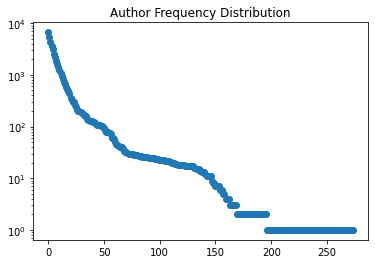


=================== Reduce documents with embeddings ===================
Original number of documents with embeddings (doc_w_embeddings) : 581780
Number of unqiue document Ids (docIds_unique) : 338848
New number of documents with embeddings (doc_w_embeddings_min_freq) : 338848
Number of interaction (interaction_min_freq) : 1148755

=================== Sparse Interaction Matrix ===================
Number of authors (authors): 48591
Number of documents (documents): 338848
Number of interactions (interactionStrength): 1148755
Number of non zero entries in interaction matrix (interaction_sparse): 1138850

=================== Convert Interaction Df to IDs ===================
Interaction dataframe matches original dataframe (interaction_min_freq == interaction_min_freq_id): False
Number of authors (auth2idx): 48591
Number of documents (doc2idx): 338848

=================== Convert Interaction Df to IDs ===================
sample index = 0
document id: 0
author id: 43060
document (from docum

,id,title,abstract,authors_split,embeddings
1,0704.1445,Deformed Wigner crystal in a one-dimensional q...,The spatial Fourier spectrum of the electron...,"[Yasha Gindikin, Vladimir A. Sablikov]","[0.06974620372056961, 0.026879271492362022, 0...."



 Document from min frequency (doc_from_min_freq from doc_w_embeddings_min_freq): 


,index,id,title,abstract,authors_split,embeddings
0,1,0704.1445,Deformed Wigner crystal in a one-dimensional q...,The spatial Fourier spectrum of the electron...,"[Yasha Gindikin, Vladimir A. Sablikov]","[0.06974620372056961, 0.026879271492362022, 0...."


In [ ]:
authors = createMinAuthFreqDataset(
    interaction_df = interaction_id, 
    doc_w_embeddings = documents_with_embeddings, 
    dataset = "min10", 
    n = 10,  
    print_output = True, 
    save = True,
    sample_index = 0)

### Min = 50


=================== Filter by Author Frequency ===================
Orginal number of interaction (interaction_df) : 2894399
new number of interaction (interaction_min_freq_id) : 386813


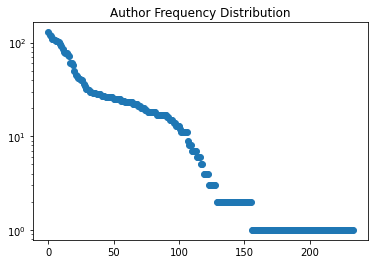


=================== Reduce documents with embeddings ===================
Original number of documents with embeddings (doc_w_embeddings) : 581780
Number of unqiue document Ids (docIds_unique) : 75872
New number of documents with embeddings (doc_w_embeddings_min_freq) : 75872
Number of interaction (interaction_min_freq) : 642459

=================== Sparse Interaction Matrix ===================
Number of authors (authors): 17834
Number of documents (documents): 75872
Number of interactions (interactionStrength): 642459
Number of non zero entries in interaction matrix (interaction_sparse): 632979

=================== Convert Interaction Df to IDs ===================
Interaction dataframe matches original dataframe (interaction_min_freq == interaction_min_freq_id): False
Number of authors (auth2idx): 17834
Number of documents (doc2idx): 75872

=================== Convert Interaction Df to IDs ===================
sample index = 0
document id: 0
author id: 9169
document (from documents): 0

,id,title,abstract,authors_split,embeddings
10,0706.0156,A Cross-disciplinary Framework for the Descrip...,We present a mathematical framework (referre...,"[Liane Gabora, Diederik Aerts]","[-0.0257490836083889, 0.05709194391965866, -0...."



 Document from min frequency (doc_from_min_freq from doc_w_embeddings_min_freq): 


,index,id,title,abstract,authors_split,embeddings
0,10,0706.0156,A Cross-disciplinary Framework for the Descrip...,We present a mathematical framework (referre...,"[Liane Gabora, Diederik Aerts]","[-0.0257490836083889, 0.05709194391965866, -0...."


In [ ]:
createMinAuthFreqDataset(
    interaction_df = interaction_id, 
    doc_w_embeddings = documents_with_embeddings, 
    dataset = "min50", 
    n = 50,  
    print_output = True, 
    save = True,
    sample_index = 0)

### Min = 100


=================== Filter by Author Frequency ===================
Orginal number of interaction (interaction_df) : 2894399
new number of interaction (interaction_min_freq_id) : 207645


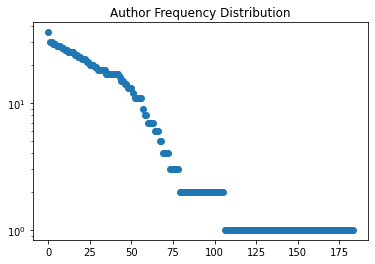


=================== Reduce documents with embeddings ===================
Original number of documents with embeddings (doc_w_embeddings) : 581780
Number of unqiue document Ids (docIds_unique) : 36057
New number of documents with embeddings (doc_w_embeddings_min_freq) : 36057
Number of interaction (interaction_min_freq) : 521053

=================== Sparse Interaction Matrix ===================
Number of authors (authors): 13125
Number of documents (documents): 36057
Number of interactions (interactionStrength): 521053
Number of non zero entries in interaction matrix (interaction_sparse): 511852

=================== Convert Interaction Df to IDs ===================
Interaction dataframe matches original dataframe (interaction_min_freq == interaction_min_freq_id): False
Number of authors (auth2idx): 13125
Number of documents (doc2idx): 36057

=================== Convert Interaction Df to IDs ===================
sample index = 0
document id: 0
author id: 11354
document (from documents): 

,id,title,abstract,authors_split,embeddings
14,0706.3282,Unified products for braided Lie bialgebras. A...,We construct unified products for braided Li...,[Tao Zhang],"[-0.06705997884273529, 0.02068275585770607, -0..."



 Document from min frequency (doc_from_min_freq from doc_w_embeddings_min_freq): 


,index,id,title,abstract,authors_split,embeddings
0,14,0706.3282,Unified products for braided Lie bialgebras. A...,We construct unified products for braided Li...,[Tao Zhang],"[-0.06705997884273529, 0.02068275585770607, -0..."


In [ ]:
createMinAuthFreqDataset(
    interaction_df = interaction_id, 
    doc_w_embeddings = documents_with_embeddings, 
    dataset = "min100", 
    n = 100,  
    print_output = True, 
    save = True,
    sample_index = 0)

## Cocitation *Study*

In [ ]:
documents_with_embeddings = pd.read_pickle("./drive/MyDrive/Colab Notebooks/CE/data/documents_with_embeddings.pickle")

In [ ]:
documents_with_embeddings.head(1)

,id,title,abstract,authors_split,embeddings
0,0704.0479,The affine part of the Picard scheme,We describe the maximal torus and maximal un...,[T.Geisser],"[-0.0015220479108393192, -0.021295614540576935..."


Find papers that cite the searched paper

In [ ]:
citations = requests.get("https://w3id.org/oc/index/api/v1/citations/10.1103/PhysRevD.76.013009")
print(json.dumps(citations.json(), indent=4))

Find papers referenced in the searched paper.

In [ ]:
references = requests.get("https://w3id.org/oc/index/api/v1/references/10.1103/PhysRevD.76.013009")
print(json.dumps(references.json(), indent=4))

In [ ]:
def listDois(endpoint, doi_array):
  retArr=[0] * len(doi_array);
  for idx, doi in enumerate(doi_array):
    retArr[idx] = requests.get("https://w3id.org/oc/index/api/v1/" + endpoint + "/" + doi).json()
  return retArr

In [ ]:
def listRecommendedCitations(doi_array):
  citObjects = listDois("citations", doi_array)
  return [set([cit["citing"][8:] for cit in paper]) for paper in citObjects]

def listCitationReferences(doi_array):
  refObjects = listDois("references", doi_array)
  return [set([ref["cited"][8:] for ref in paper]) for paper in refObjects]

In [ ]:
def calculateCoCitations(doi, recommended_dois, printOutput=False):
  citations = requests.get("https://w3id.org/oc/index/api/v1/citations/" + doi).json()
  references = requests.get("https://w3id.org/oc/index/api/v1/references/" + doi).json()

  if (printOutput):
    print(json.dumps(citations.json(), indent=4))
  
  citation_dois = [citation["citing"][8:] for citation in citations]
  reference_dois = [reference["cited"][8:] for reference in references]

  coCitationCount = 0
  citedCount = 0
  refCount = 0
  recommended_dois_set = set(recommended_dois)
  for doi in citation_dois:
    if doi in recommended_dois_set:
      citedCount+=1
  
  for doi in reference_dois:
    if doi in recommended_dois_set:
      refCount+=1

  if len(citation_dois) < len(recommended_dois):
    # get a list of dois that have cited the recomended papers
    recommended_citation_dois = listRecommendedCitations(recommended_dois)
    for doi in citation_dois:
      for rec_doi_set in recommended_citation_dois:
        # check if any of the papers that cited our input doi (citation_dois) also cited the any of the recommended dois (recommended_citation_dois)
        if doi in rec_doi_set:
          coCitationCount+=1

  else:
    # get a list of references for each paper that has cited our input doi
    citation_references = listCitationReferences(citation_dois)
    for doi in recommended_dois:
      for citation_reference_set in citation_references:
        # check if our recommended dois (recommended_dois) are also used as references in the list of dois that have cited our input (citation_references)
        if doi in citation_reference_set:
          coCitationCount+=1 


  return { "coCitationCount": coCitationCount, "citedCount": citedCount, "refCount": refCount}
          

In [ ]:
cited = "10.1103/physrevd.76.013009"
citing = ["10.1140/epjc/s10052-021-09687-4","10.1007/jhep04(2021)041", "10.1103/physrevlett.95.022003", "10.1103/physrevlett.85.4678"] 

print(calculateCoCitations(cited, citing))

{'coCitationCount': 14, 'citedCount': 2, 'refCount': 2}


## Sources


*   https://www.smithsonianmag.com/smart-news/half-academic-studies-are-never-read-more-three-people-180950222/
*   https://www.kaggle.com/onyonixch/scientific-paper-clustering
*   https://towardsdatascience.com/recommender-systems-item-customer-collaborative-filtering-ff0c8f41ae8a
*   https://github.com/maziarraissi/Applied-Deep-Learning/blob/main/08%20-%20Recommender%20Systems.pdf
*   https://towardsdatascience.com/how-spotify-recommends-your-new-favorite-artist-8c1850512af0
*   https://nbviewer.org/github/cbowdon/doc2vec-pytorch/blob/master/doc2vec.ipynb



